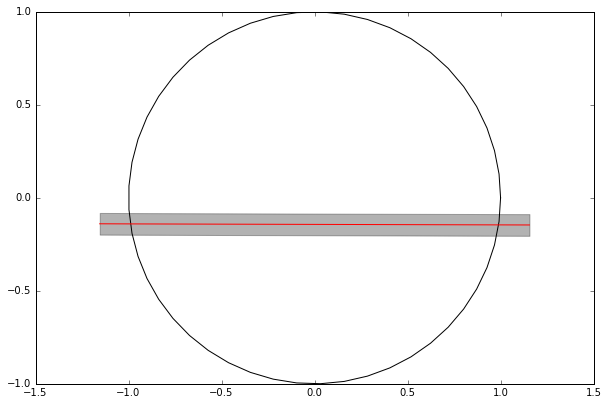

In [48]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Import dev version of friedrich:
import sys
sys.path.insert(0, '../')
from friedrich.lightcurve import hat11_params_morris
from friedrich.orientation import planet_position_cartesian

transit_params = hat11_params_morris()
start = 0.5
n_times = 1000
interp_duration = 0.005 # fraction of full transit duration
times1 = np.linspace(transit_params.t0 - transit_params.duration/2 - interp_duration, 
                     transit_params.t0 - transit_params.duration/2 + interp_duration, n_times)
times2 = np.linspace(transit_params.t0 + transit_params.duration/2 - interp_duration, 
                     transit_params.t0 + transit_params.duration/2 + interp_duration, n_times)

times = np.concatenate([times1, times2])

x_center, y_center, z_center = planet_position_cartesian(times, transit_params)

y_plus = y_center + transit_params.rp
y_minus = y_center - transit_params.rp

theta = np.linspace(0, 2*np.pi, 50)

fig, ax = plt.subplots(figsize=(10,10))
ax.plot(np.cos(theta), np.sin(theta), color='k')
ax.plot(x_center, y_center, color='r')
#ax.scatter(x, y)
ax.fill_between(x_center, y_minus, y_plus, color='k', alpha=0.3)

ax.set_aspect('equal')

In [59]:
def interp_y_upper(x):
    return np.interp(x, x_center, y_plus)

def interp_y_lower(x):
    return np.interp(x, x_center, y_minus)

def circle_y_negative(x):
    return -np.sqrt(1**2 - x**2)

from scipy.optimize import fmin

def minimize_for_upper(x):
    return np.abs(circle_y_negative(x) - interp_y_upper(x))

def minimize_for_lower(x):
    return np.abs(circle_y_negative(x) - interp_y_lower(x))

initp = [-1.0]
x_ingress_intercept_upper = fmin(minimize_for_upper, initp)[0]
x_ingress_intercept_lower = fmin(minimize_for_lower, initp)[0]

initp = [1.0]
x_egress_intercept_upper = fmin(minimize_for_upper, initp)[0]
x_egress_intercept_lower = fmin(minimize_for_lower, initp)[0]

Optimization terminated successfully.
         Current function value: 0.000060
         Iterations: 15
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000055
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 0.000243
         Iterations: 13
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000223
         Iterations: 11
         Function evaluations: 22


/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in sqrt


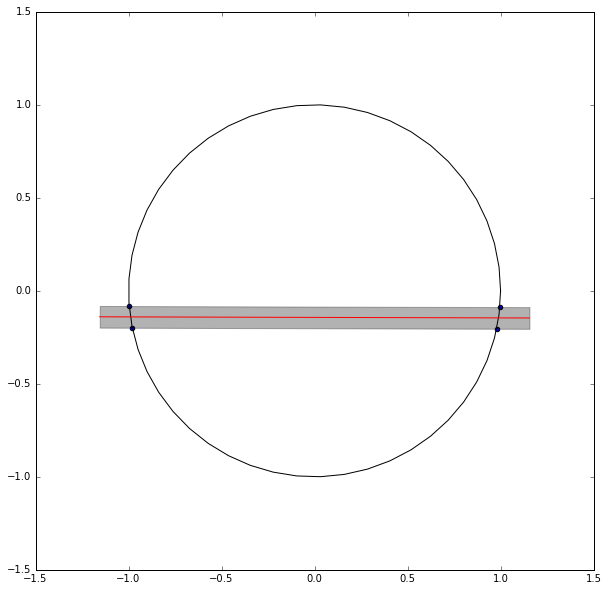

In [64]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(np.cos(theta), np.sin(theta), color='k')
ax.plot(x_center, y_center, color='r')

ax.scatter(x_ingress_intercept_upper, circle_y_negative(x_ingress_intercept_upper))
ax.scatter(x_ingress_intercept_lower, circle_y_negative(x_ingress_intercept_lower))

ax.scatter(x_egress_intercept_upper, circle_y_negative(x_egress_intercept_upper))
ax.scatter(x_egress_intercept_lower, circle_y_negative(x_egress_intercept_lower))

ax.fill_between(x_center, y_minus, y_plus, color='k', alpha=0.3)

ax.set_aspect('equal')

***

Area occulted by a single transit:

In [73]:
from scipy.integrate import quad

def rho(y):
    """Radius at a given latitude (latitude = y)"""
    return np.sqrt(1 - y**2)

def half_circumference(y):
    """Half-circumference at a given latitude (latitude = y)"""
    return np.pi * rho(y)

y_lower_bound = transit_params.b - transit_params.rp
y_upper_bound = transit_params.b + transit_params.rp

surface_area = quad(half_circumference, y_lower_bound, y_upper_bound)[0]
print("fractional surface area occulted: {0}".format(surface_area/(4*np.pi)))

fractional surface area occulted: 0.02884647053276666


Sanity check:

In [76]:
# Full-width of the star in x at the transit-chord center:
chord_length = 2*np.sqrt(1 - transit_params.b**2)
planet_diameter = 2*transit_params.rp

approximate_surface_area = planet_diameter * chord_length
print('approximate fractional sky-projected area: {0}'
      .format(approximate_surface_area/(4*np.pi)))

approximate fractional sky-projected area: 0.018375102160109208
